In [1]:
# import trax
# from trax import layers as tl
# import trax.fastmath.numpy as fastnp
# from trax.supervised import training
from functools import partial
import numpy as np
from itertools import combinations
import random as rnd
from random import sample
import json
import sklearn.metrics as metrics
from sklearn.metrics import classification_report , confusion_matrix, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import copy
import torch
import os
import warnings
from scipy.spatial import distance
from os import walk
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#initialize codebert
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model_codebert = AutoModel.from_pretrained("microsoft/codebert-base").to(device)
np.random.seed(123456)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from os import walk

from transformers import AutoModelForCausalLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
v0_data_dir = '../data/test_files_v0'
# v12_data_dir = '../data/test_files_v12'


# Replace the path with your own. 
filenames_v0 = next(walk(v0_data_dir), (None, None, []))[2] 
# filenames_v12 = next(walk(v12_data_dir), (None, None, []))[2] 


categories =  {}
for file in filenames_v0:
    label = (file.split("@")[1]).split('.')[0].strip().lower() 
    if label not in categories.keys() : 
        categories[label] = 0
    categories[label] += 1 

# for file in filenames_v12:
#     label = (file.split("@")[1]).split('.')[0].strip().lower() 
#     if label not in categories.keys() : 
#         categories[label] = 0
#     categories[label] += 1   
    
print("\n==> All data : \n")
for x , y in categories.items() :
    print(x , y)




==> All data : 

test order dependency 103
randomness 17
time 42
network 31
platform dependency 2
resource leak 10
async wait 125
test case timeout 14
concurrency 48
unordered collections 51
floating point operations 3
too restrictive range 3
i_o 2


In [4]:
from sklearn.model_selection import train_test_split
buggy_code = []
filenames = []

for file in filenames_v0:
    label = (file.split("@")[1]).split('.')[0].strip().lower() 
    if label == 'async wait':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'unordered collections':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'concurrency':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'time':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'test order dependency':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)

        
# for file in filenames_v12:
#     label = (file.split("@")[1]).split('.')[0].strip().lower() 
#     if label == 'async wait':
#         with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
#             buggy_code.append(buggy_file.read())
#             filenames.append(file)
#     elif label == 'unordered collections':
#         with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
#             buggy_code.append(buggy_file.read())
#             filenames.append(file)
#     elif label == 'concurrency':
#         with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
#             buggy_code.append(buggy_file.read())
#             filenames.append(file)
#     elif label == 'time':
#         with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
#             buggy_code.append(buggy_file.read())
#             filenames.append(file)
#     elif label == 'test order dependency':
#         with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
#             buggy_code.append(buggy_file.read())
#             filenames.append(file)

        
train_buggy_code, valid_buggy_code = train_test_split(buggy_code, test_size=0.2, random_state=42)
train_filenames, valid_filenames = train_test_split(filenames,test_size=0.2,random_state=42)

In [5]:
label_to_int= {
    'async wait': 0,
    'unordered collections': 1,
    'concurrency': 2,
    'time': 3,
    'test order dependency': 4
}

In [6]:
from torch.utils.data import Dataset
import numpy as np
import random
m_len = 3402
class SiameseDataset(Dataset):
    def __init__(self, buggy_code, tokenizer, codebert, filenames, split):
        self.buggy_code = buggy_code
        self.tokenizer = tokenizer
        self.codebert = codebert.to(device)
        self.filenames = filenames
        self.split = split
        self.max_len = 0
        
        # Preprocess filenames to map labels to indices
        self.label_to_indices = {}
        for index, filename in enumerate(filenames):
            label = self._extract_label(filename)
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(index)

        # For negative sampling
        self.labels = [self._extract_label(filename) for filename in filenames]
        self.unique_labels = list(set(self.labels))

    def __len__(self):
        return len(self.buggy_code)

    def __getitem__(self, idx):
        if self.split == 'train':
            # Anchor label
            anchor_label = self._extract_label(self.filenames[idx])

            # Positive sample
            positive_idx = idx
            while positive_idx == idx:  # Ensure different indices for anchor and positive
                positive_idx = random.choice(self.label_to_indices[anchor_label])

            # Negative sample
            negative_label = random.choice([lab for lab in self.unique_labels if lab != anchor_label])
            negative_idx = random.choice(self.label_to_indices[negative_label])


            anchor = self._process_snippet(self.buggy_code[idx])
            positive = self._process_snippet(self.buggy_code[positive_idx])
            negative = self._process_snippet(self.buggy_code[negative_idx])
            if len(anchor) <= 768:
                short_data = True
            else:
                short_data = False

            return {
                'anchor': torch.nn.functional.pad(anchor, (0, m_len - anchor.size(0))),
                'positive': torch.nn.functional.pad(positive, (0, m_len - positive.size(0))),
                'negative': torch.nn.functional.pad(negative, (0, m_len - negative.size(0))),
                'label': anchor_label,  # Optional, depends on how you want to use it
                'short_data_flag': short_data
            }
        elif self.split =='val':
            anchor_label = self._extract_label(self.filenames[idx])
            anchor = self._process_snippet(self.buggy_code[idx])
            
            return {
                'anchor': torch.nn.functional.pad(anchor, (0, m_len - anchor.size(0))),
                'label': anchor_label  # Optional, depends on how you want to use it
            }
        
    def _extract_label(self, filename):
        # Implement logic to extract label from filename
        return label_to_int[(filename.split("@")[1]).split('.')[0].strip().lower()]

    def _process_snippet(self, snippet):
        import torch

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Tokenize input without the max_length constraint
        inputs = self.tokenizer(snippet, return_tensors='pt').to(device)

        if inputs['input_ids'].shape[1] < 512:

            with torch.no_grad():
                outs = self.codebert(**inputs)
            cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
            return cls  # Move to CPU to save GPU memory
        else:

            total_length = inputs['input_ids'].shape[1]
            # if total_length >= self.max_len:
            #     self.max_len = total_length
            #     print(self.max_len)
            parts = []
            step_size = 100
            chunk_size = 512

            for start_index in range(0, total_length, step_size):
                end_index = min(start_index + chunk_size, total_length)
                input_segment = {key: val[:, start_index:end_index].to(device) for key, val in inputs.items()}

                with torch.no_grad():
                    output_segment = self.codebert(**input_segment)
                cls_segment = output_segment.last_hidden_state[:, 0, :].squeeze().detach()
                parts.append(cls_segment)  # Move to CPU

                # del input_segment, output_segment, cls_segment  # Free up memory
                # torch.cuda.empty_cache()  # Clear cache
                # gc.collect()  # Invoke garbage collector

            concatenated_parts = torch.cat(parts, dim=0)
            return concatenated_parts


        
        # #CHECKING WHAT HAPPENS WHEN WE REMOVE MAX LENGTH CONSTRAINT
        # inputs = self.tokenizer(snippet, return_tensors='pt').to(device)
        # #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
        # print(inputs['input_ids'].shape[1])
        # if((inputs['input_ids'].shape[1])<512):
        #     with torch.no_grad():
        #         outs = self.codebert(**inputs)
        #     cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        #     return cls
        # else:
        #     print('longtest')
        #     i = 0
        #     part_vector =  []
        #     while ( i < (inputs['input_ids'].shape[1])-200) :
        #         print('in while')
        #         #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
        #         #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
        #         input_seg = [self.tokenizer.cls_token] + inputs['input_ids'][1][i:i+250] +[self.tokenizer.sep_token]
        #         with torch.no_grad():
        #             ots = self.codebert(**input_seg)
        #         cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
        #         #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
        #         #vector = cls[0].detach().numpy()
        #         parts.append(cls)
        #         i = i+100
        #     return parts
            
            

In [7]:

# Create instances of the custom dataset class
train_dataset = SiameseDataset(train_buggy_code, tokenizer, model_codebert, train_filenames, 'train')
val_dataset = SiameseDataset(valid_buggy_code, tokenizer, model_codebert, valid_filenames, 'val')


# Create dataloaders for training and validation
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [8]:
import numpy as np

def sample_triplet_data(data, sample_size_ratio):
    """
    Samples a subset of triplet data (anchor, positive, negative) while preserving class distribution.
    
    Parameters:
    - data: list of dictionaries, where each dictionary has keys 'anchor', 'positive', 'negative', 'label'.
    - sample_size_ratio: float, the fraction of the data to sample (0 < sample_size_ratio <= 1).
    
    Returns:
    - sampled_data: list of dictionaries, the sampled subset of the original data.
    """
    # Extract labels to understand the class distribution
    labels = [item['label'] for item in data]
    unique_classes = np.unique(labels)
    
    sampled_data = []
    
    for cls in unique_classes:
        # Find all items belonging to the current class
        class_items = [item for item in data if item['label'] == cls]
        # Calculate the number of items to sample from this class
        num_samples = int(np.ceil(len(class_items) * sample_size_ratio))
        # Randomly sample items without replacement
        sampled_items = np.random.choice(class_items, size=num_samples, replace=False)
        # Append the sampled items to the output list
        sampled_data.extend(sampled_items)
    
    # Optionally, shuffle the sampled dataset to mix classes
    np.random.shuffle(sampled_data)

    return sampled_data


In [9]:
import gc
from tqdm import tqdm
plot_data = []
plot_labels = []
short_data_flags = []
for item in tqdm(train_dataset):
    
    plot_data.append(item['anchor'])
    plot_labels.append(item['label'])
    short_data_flags.append(item['short_data_flag'])

100%|██████████| 295/295 [00:33<00:00,  8.90it/s]


In [10]:

# Assuming plot_data is a list of 1D tensors of different lengths
max_length = max(tensor.size(0) for tensor in plot_data)
padded_data = [torch.nn.functional.pad(tensor, (0, max_length - tensor.size(0))) for tensor in plot_data]

In [11]:
max_length

3402

In [12]:
colors = ['#CC1D1F', '#1DCC28', '#1D37CC', '#CC9D1D', '#BA1DCC']  # Red, Green, Blue, Yellow, Purple
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap
cc = LinearSegmentedColormap.from_list("cc", colors, N=5)


In [13]:
# !python3 -m pip install matplotlib==3.5.2

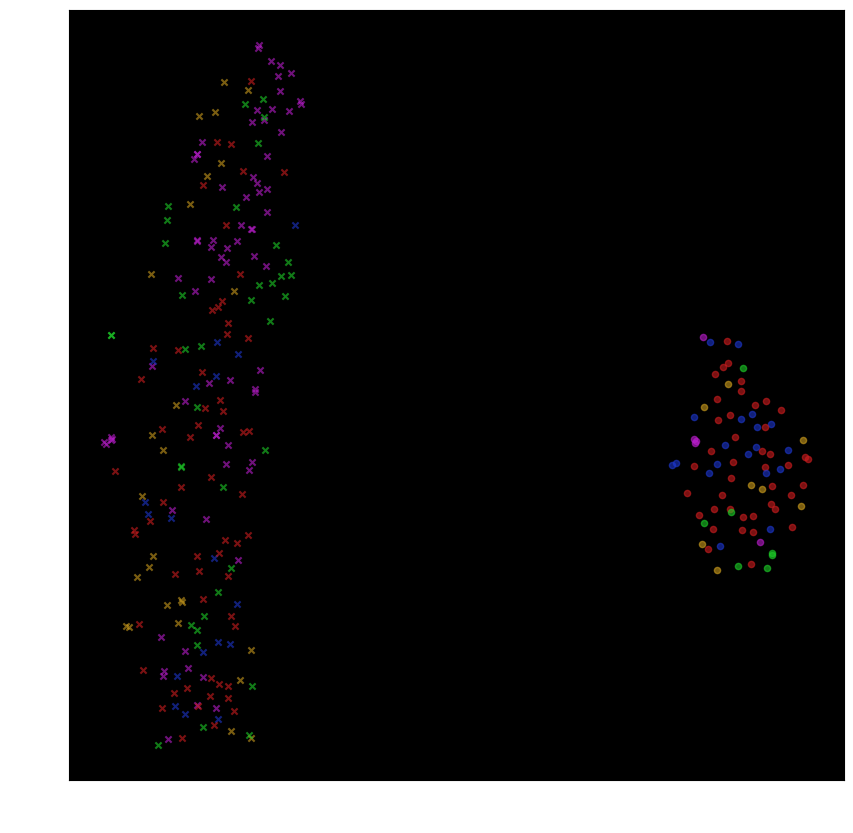

In [14]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np

# Assuming X, plot_data, and plot_labels are defined as before
# Also assuming bool_values is your list/array of boolean values

X = torch.stack(plot_data).cpu().numpy()

# Extract labels for each point
labelsNums = plot_labels

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# Assuming 'cc' is a colormap, you might need to adjust this to fit your actual colormap variable
# Generate an array of colors for each label
unique_labels = np.unique(labelsNums)
colors = plt.cm.get_cmap(cc, len(unique_labels))  # Adjust 'cc' as needed to your colormap name
label_to_color = {label: colors(i / len(unique_labels)) for i, label in enumerate(unique_labels)}
colors_array = np.array([label_to_color[label] for label in labelsNums])

# Create the scatter plot
plt.figure(figsize=(10, 10))

# Iterate through each datapoint
for i in range(len(X_embedded)):
    marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors_array[i], s=20, alpha=0.6, marker=marker)

# Set the background color to black
plt.gca().set_facecolor('black')
# Adjust the color of the ticks and labels for better visibility
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.xlabel('Component 1', color='white')
plt.ylabel('Component 2', color='white')

plt.show()


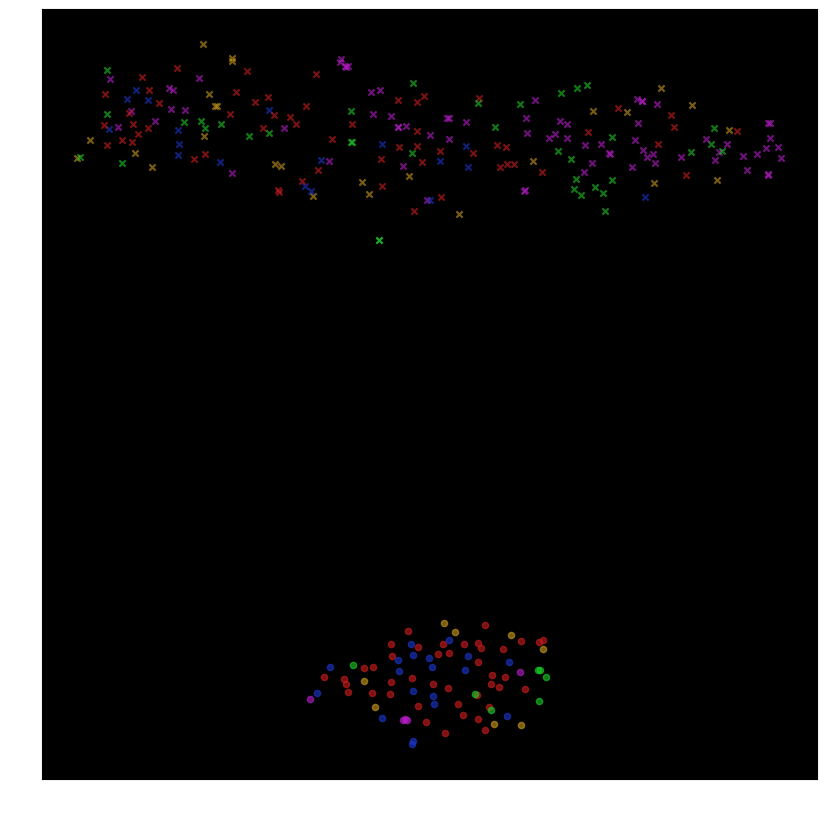

In [15]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from sklearn.preprocessing import MinMaxScaler

X = torch.stack(plot_data).cpu().numpy()
labelsNums = plot_labels

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# Normalize the points
scaler = MinMaxScaler()
X_embedded_normalized = scaler.fit_transform(X_embedded)

# Create the scatter plot
plt.figure(figsize=(10, 10))
for i in range(len(X_embedded_normalized)):
    marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
    plt.scatter(X_embedded_normalized[i, 0], X_embedded_normalized[i, 1], color=colors_array[i], s=20, alpha=0.6, marker=marker)

# Set the background color to black
plt.gca().set_facecolor('black')
# Adjust the color of the ticks and labels for better visibility
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.show()


In [16]:
# Load the CodeBERT tokenizer (adjust the model_name as needed)
model_name = "microsoft/codebert-base"
codebert_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_size, int(embedding_size/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/2), int(embedding_size/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/4), embedding_size)
        )

    def forward(self, x):
        output = self.fc(x)
        return output

In [17]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [18]:
learning_rate = 5e-6
num_epochs = 200
embed_size = m_len  # This should match the output size of CodeBERT
siamese_network = SiameseNetwork(embed_size).to(device)
criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(siamese_network.parameters(), lr=learning_rate)
triplet_loss = TripletLoss().to(device)

In [19]:
# from transformers import get_linear_schedule_with_warmup
# warmup_Frac = 0.1
# total_iter = num_epochs * len(train_dataloader)
# scheduler = get_linear_schedule_with_warmup(optimizer, int(warmup_Frac * total_iter), total_iter)

In [20]:
from tqdm import tqdm
best_loss = 100.0
num_epochs = 400
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter('logs/flakyXbert_300_seed123456')
epoch_loss_list = []
for epoch in range(num_epochs):
    total_loss = 0.01
    siamese_network.train()
    for batch in tqdm(train_dataloader):

        labels = (batch['label']).to(device)
        batch_anchor = (batch['anchor']).to(device)
        batch_positive = (batch['positive']).to(device)
        batch_negative = (batch['negative']).to(device)

        anchor_output = siamese_network(batch_anchor)
        positive_out = siamese_network(batch_positive)
        negative_out = siamese_network(batch_negative)

        loss = criterion(anchor_output, positive_out, negative_out)
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(siamese_network.parameters(), max_norm=2.0)        
        optimizer.step()
        # scheduler.step()
        writer.add_scalar('Training Loss', loss.item(), epoch * len(train_dataloader) + i)
        total_loss += loss.item()
        if total_loss <= best_loss:
            # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
            print("Loss improved saving model")
            torch.save(siamese_network.state_dict(), 'flakyXbert_300_seed123456.pth')
            best_loss = total_loss
        
            
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    

2024-06-18 04:28:28.133449: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 04:28:28.148996: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 04:28:28.149013: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 04:28:28.149026: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 04:28:28.152405: I tensorflow/core/platform/cpu_feature_g

Loss improved saving model


100%|██████████| 37/37 [00:36<00:00,  1.03it/s]


Epoch 1/400, Loss: 1.6272226816254693


  3%|▎         | 1/37 [00:01<00:46,  1.30s/it]

Loss improved saving model


100%|██████████| 37/37 [00:37<00:00,  1.01s/it]


Epoch 2/400, Loss: 0.9317383462673908


  3%|▎         | 1/37 [00:00<00:30,  1.19it/s]

Loss improved saving model


100%|██████████| 37/37 [00:37<00:00,  1.02s/it]


Epoch 3/400, Loss: 0.937678833523312


  3%|▎         | 1/37 [00:01<00:37,  1.03s/it]

Loss improved saving model


100%|██████████| 37/37 [00:38<00:00,  1.04s/it]


Epoch 4/400, Loss: 0.9352895563679772


100%|██████████| 37/37 [00:37<00:00,  1.02s/it]


Epoch 5/400, Loss: 0.9633704805051958


100%|██████████| 37/37 [00:26<00:00,  1.40it/s]


Epoch 6/400, Loss: 0.909966483567212


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 7/400, Loss: 0.9045682342632396


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 8/400, Loss: 0.8667938341321172


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 9/400, Loss: 0.9146165737590274


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 10/400, Loss: 0.9243875583442481


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 11/400, Loss: 0.9185040080225145


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 12/400, Loss: 0.8476268732225573


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 13/400, Loss: 0.8435706643800477


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 14/400, Loss: 0.9337264156985927


100%|██████████| 37/37 [00:13<00:00,  2.84it/s]


Epoch 15/400, Loss: 0.9293861891127921


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 16/400, Loss: 0.8851592398334194


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 17/400, Loss: 0.870063338988536


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 18/400, Loss: 0.8385772619054124


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 19/400, Loss: 0.8700652398934234


100%|██████████| 37/37 [00:11<00:00,  3.34it/s]


Epoch 20/400, Loss: 0.8542792477478851


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 21/400, Loss: 0.8561431961446194


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 22/400, Loss: 0.8363320016538774


  3%|▎         | 1/37 [00:00<00:12,  2.92it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 23/400, Loss: 0.8518316603351284


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 24/400, Loss: 0.7759454462334916


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 25/400, Loss: 0.7832209341590468


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 26/400, Loss: 0.8008093788172748


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 27/400, Loss: 0.7956589422677014


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 28/400, Loss: 0.7920270049249803


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 29/400, Loss: 0.7556188334645452


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 30/400, Loss: 0.7114418707344983


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 31/400, Loss: 0.6931378554009102


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 32/400, Loss: 0.7008489977024697


100%|██████████| 37/37 [00:11<00:00,  3.25it/s]


Epoch 33/400, Loss: 0.7162980423746882


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 34/400, Loss: 0.6840837946775796


  3%|▎         | 1/37 [00:00<00:17,  2.12it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 35/400, Loss: 0.7217289493857203


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 36/400, Loss: 0.7130130765566954


100%|██████████| 37/37 [00:10<00:00,  3.41it/s]


Epoch 37/400, Loss: 0.6505368386732565


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 38/400, Loss: 0.699454269956898


  3%|▎         | 1/37 [00:00<00:18,  1.96it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 39/400, Loss: 0.6763218780788215


100%|██████████| 37/37 [00:10<00:00,  3.40it/s]


Epoch 40/400, Loss: 0.6682087515818106


  3%|▎         | 1/37 [00:00<00:13,  2.59it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 41/400, Loss: 0.5832400413139446


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 42/400, Loss: 0.6008957087349247


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 43/400, Loss: 0.577637709330868


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 44/400, Loss: 0.6437058543997841


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 45/400, Loss: 0.5963911936250892


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 46/400, Loss: 0.5626283924885698


100%|██████████| 37/37 [00:11<00:00,  3.35it/s]


Epoch 47/400, Loss: 0.5523995075032517


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 48/400, Loss: 0.5556164416670799


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 49/400, Loss: 0.5742212915098345


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 50/400, Loss: 0.5527441445798487


100%|██████████| 37/37 [00:11<00:00,  3.36it/s]


Epoch 51/400, Loss: 0.5261846465194547


100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


Epoch 52/400, Loss: 0.5074187304280899


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 53/400, Loss: 0.531351169678005


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 54/400, Loss: 0.5433231324924005


100%|██████████| 37/37 [00:11<00:00,  3.25it/s]


Epoch 55/400, Loss: 0.49944289255786584


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 56/400, Loss: 0.5303463273918306


  3%|▎         | 1/37 [00:00<00:14,  2.50it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 57/400, Loss: 0.49698836321766304


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 58/400, Loss: 0.5121232636232633


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 59/400, Loss: 0.5329438021617966


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 60/400, Loss: 0.5279901251760688


100%|██████████| 37/37 [00:11<00:00,  3.33it/s]


Epoch 61/400, Loss: 0.4961859344791721


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 62/400, Loss: 0.5073059908602688


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 63/400, Loss: 0.47551855410273003


100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


Epoch 64/400, Loss: 0.475073643890587


  3%|▎         | 1/37 [00:00<00:10,  3.52it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 65/400, Loss: 0.5260193334399043


100%|██████████| 37/37 [00:10<00:00,  3.56it/s]


Epoch 66/400, Loss: 0.3724383184797055


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 67/400, Loss: 0.45598085471907174


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 68/400, Loss: 0.47992167204618447


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 69/400, Loss: 0.3980698137025575


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 70/400, Loss: 0.5188081925543578


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 71/400, Loss: 0.42596655203683953


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 72/400, Loss: 0.40742953449487684


100%|██████████| 37/37 [00:11<00:00,  3.30it/s]


Epoch 73/400, Loss: 0.456742241833661


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 74/400, Loss: 0.3995443754260604


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 75/400, Loss: 0.37917495665518014


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 76/400, Loss: 0.4028239925326528


100%|██████████| 37/37 [00:11<00:00,  3.33it/s]


Epoch 77/400, Loss: 0.3902915531477413


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:10<00:00,  3.40it/s]


Epoch 78/400, Loss: 0.3564965473800092


100%|██████████| 37/37 [00:10<00:00,  3.50it/s]


Epoch 79/400, Loss: 0.349457194128552


100%|██████████| 37/37 [00:11<00:00,  3.31it/s]


Epoch 80/400, Loss: 0.3988251787343541


100%|██████████| 37/37 [00:11<00:00,  3.31it/s]


Epoch 81/400, Loss: 0.511969120776331


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 82/400, Loss: 0.41273447172061817


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 83/400, Loss: 0.3847582195820035


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 84/400, Loss: 0.35355602452078383


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 85/400, Loss: 0.39763400709306873


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 86/400, Loss: 0.420274780666506


100%|██████████| 37/37 [00:11<00:00,  3.29it/s]


Epoch 87/400, Loss: 0.3803646007260761


100%|██████████| 37/37 [00:10<00:00,  3.50it/s]


Epoch 88/400, Loss: 0.4453521172098211


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 89/400, Loss: 0.3663420484436525


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 90/400, Loss: 0.3712128206040408


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 91/400, Loss: 0.36218156167784255


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 92/400, Loss: 0.3623778860875078


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 93/400, Loss: 0.3169008514123994


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 94/400, Loss: 0.36682007205647393


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 95/400, Loss: 0.36270273683844384


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 96/400, Loss: 0.35512758414487583


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 97/400, Loss: 0.34358592921012154


100%|██████████| 37/37 [00:11<00:00,  3.34it/s]


Epoch 98/400, Loss: 0.32716613590717314


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 99/400, Loss: 0.3649866831222096


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 100/400, Loss: 0.3429166467769726


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 101/400, Loss: 0.3526084055127324


100%|██████████| 37/37 [00:10<00:00,  3.40it/s]


Epoch 102/400, Loss: 0.3467419923318399


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 103/400, Loss: 0.35315132992493137


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 104/400, Loss: 0.315695841626541


100%|██████████| 37/37 [00:10<00:00,  3.44it/s]


Epoch 105/400, Loss: 0.3416454755837047


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 106/400, Loss: 0.3559849097680401


100%|██████████| 37/37 [00:10<00:00,  3.43it/s]


Epoch 107/400, Loss: 0.37003881489908375


100%|██████████| 37/37 [00:13<00:00,  2.83it/s]


Epoch 108/400, Loss: 0.2845111352930198


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 109/400, Loss: 0.34926243152167347


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 110/400, Loss: 0.29716847580832406


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 111/400, Loss: 0.2597011147077019


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 112/400, Loss: 0.29785647993957676


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 113/400, Loss: 0.34195209924433684


100%|██████████| 37/37 [00:10<00:00,  3.44it/s]


Epoch 114/400, Loss: 0.3544746390226725


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 115/400, Loss: 0.3118922618353689


100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


Epoch 116/400, Loss: 0.3783232187660965


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 117/400, Loss: 0.2661514882864179


100%|██████████| 37/37 [00:11<00:00,  3.36it/s]


Epoch 118/400, Loss: 0.2917522824857686


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 119/400, Loss: 0.3120809741680686


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 120/400, Loss: 0.2892703191009728


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 121/400, Loss: 0.3101773614980079


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 122/400, Loss: 0.2978038713899819


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 123/400, Loss: 0.300449322864816


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 124/400, Loss: 0.2739456140471471


100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


Epoch 125/400, Loss: 0.29763724016176685


  3%|▎         | 1/37 [00:00<00:09,  3.91it/s]

Loss improved saving model


100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


Epoch 126/400, Loss: 0.3047196744825389


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 127/400, Loss: 0.2660281953235736


100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


Epoch 128/400, Loss: 0.32260401673413613


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 129/400, Loss: 0.33734658607759993


100%|██████████| 37/37 [00:10<00:00,  3.38it/s]


Epoch 130/400, Loss: 0.3217991047372689


100%|██████████| 37/37 [00:10<00:00,  3.48it/s]


Epoch 131/400, Loss: 0.2976269869546632


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 132/400, Loss: 0.3322584309449067


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 133/400, Loss: 0.3182322733869424


  3%|▎         | 1/37 [00:00<00:19,  1.81it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 134/400, Loss: 0.23970864759103672


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 135/400, Loss: 0.23276021518417306


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 136/400, Loss: 0.25640743030084145


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 137/400, Loss: 0.27743989637574634


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 138/400, Loss: 0.32204460801304996


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 139/400, Loss: 0.28189163781501153


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 140/400, Loss: 0.2684635913210946


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 141/400, Loss: 0.3270135453987766


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 142/400, Loss: 0.29240877509117125


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 143/400, Loss: 0.22958406308212795


100%|██████████| 37/37 [00:10<00:00,  3.54it/s]


Epoch 144/400, Loss: 0.2707340844740739


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 145/400, Loss: 0.2306335651552355


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 146/400, Loss: 0.2264615589863545


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 147/400, Loss: 0.23704629819940876


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 148/400, Loss: 0.25815481657917433


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 149/400, Loss: 0.22702102429157978


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 150/400, Loss: 0.20610715796818604


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 151/400, Loss: 0.26912389822102883


100%|██████████| 37/37 [00:11<00:00,  3.35it/s]


Epoch 152/400, Loss: 0.24059356029774692


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 153/400, Loss: 0.30272696414509337


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 154/400, Loss: 0.20343747821208594


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 155/400, Loss: 0.2050306767386359


100%|██████████| 37/37 [00:11<00:00,  3.34it/s]


Epoch 156/400, Loss: 0.24547156878419824


100%|██████████| 37/37 [00:11<00:00,  3.34it/s]


Epoch 157/400, Loss: 0.23124797386092108


  3%|▎         | 1/37 [00:00<00:10,  3.46it/s]

Loss improved saving model


100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


Epoch 158/400, Loss: 0.18673658014149278


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 159/400, Loss: 0.26120603956080773


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 160/400, Loss: 0.23682988581625192


100%|██████████| 37/37 [00:11<00:00,  3.35it/s]


Epoch 161/400, Loss: 0.21153423799856289


  3%|▎         | 1/37 [00:00<00:27,  1.30it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:01<00:22,  1.58it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 162/400, Loss: 0.24505422853940242


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 163/400, Loss: 0.24900473035670614


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 164/400, Loss: 0.20077162181203428


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 165/400, Loss: 0.22318614964549605


100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


Epoch 166/400, Loss: 0.2502756761699109


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 167/400, Loss: 0.2561916411486832


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 168/400, Loss: 0.24842712651233415


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 169/400, Loss: 0.19286319739915228


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 170/400, Loss: 0.2810764115968266


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 171/400, Loss: 0.21411499789437732


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 172/400, Loss: 0.20742539624104628


100%|██████████| 37/37 [00:11<00:00,  3.33it/s]


Epoch 173/400, Loss: 0.23364485302486934


100%|██████████| 37/37 [00:11<00:00,  3.34it/s]


Epoch 174/400, Loss: 0.21223517090082167


100%|██████████| 37/37 [00:10<00:00,  3.40it/s]


Epoch 175/400, Loss: 0.2584908619281408


100%|██████████| 37/37 [00:11<00:00,  3.30it/s]


Epoch 176/400, Loss: 0.24808267731118847


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 177/400, Loss: 0.20414662729243974


100%|██████████| 37/37 [00:11<00:00,  3.29it/s]


Epoch 178/400, Loss: 0.18453138226592863


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 179/400, Loss: 0.20703019699484512


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 180/400, Loss: 0.2119938618991826


100%|██████████| 37/37 [00:10<00:00,  3.38it/s]


Epoch 181/400, Loss: 0.18987596201735574


  3%|▎         | 1/37 [00:00<00:14,  2.50it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.25it/s]


Epoch 182/400, Loss: 0.17677365973994538


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 183/400, Loss: 0.22106961549133866


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 184/400, Loss: 0.26144952634701857


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 185/400, Loss: 0.18114459681349832


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 186/400, Loss: 0.21781307263148797


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 187/400, Loss: 0.21706521416032637


100%|██████████| 37/37 [00:11<00:00,  3.36it/s]


Epoch 188/400, Loss: 0.16715665549845307


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 189/400, Loss: 0.21253634531755705


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 190/400, Loss: 0.22336124533737028


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 191/400, Loss: 0.20009888512862695


100%|██████████| 37/37 [00:10<00:00,  3.52it/s]


Epoch 192/400, Loss: 0.2516794509339977


100%|██████████| 37/37 [00:10<00:00,  3.49it/s]


Epoch 193/400, Loss: 0.17413550862589397


100%|██████████| 37/37 [00:10<00:00,  3.47it/s]


Epoch 194/400, Loss: 0.18544546339157464


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 195/400, Loss: 0.1568218738001746


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 196/400, Loss: 0.21868179653544684


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 197/400, Loss: 0.21336096248916678


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 198/400, Loss: 0.1793002488806441


100%|██████████| 37/37 [00:11<00:00,  3.35it/s]


Epoch 199/400, Loss: 0.25839169610996504


100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


Epoch 200/400, Loss: 0.21977922426687704


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 201/400, Loss: 0.2228541707025992


  3%|▎         | 1/37 [00:00<00:10,  3.57it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 202/400, Loss: 0.21409316648502608


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 203/400, Loss: 0.19486648433917278


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 204/400, Loss: 0.19557512778688121


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 205/400, Loss: 0.1663570054237907


100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


Epoch 206/400, Loss: 0.158657633227271


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 207/400, Loss: 0.2140768384369644


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 208/400, Loss: 0.1622776021184148


100%|██████████| 37/37 [00:11<00:00,  3.25it/s]


Epoch 209/400, Loss: 0.18841207898951864


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 210/400, Loss: 0.1881467807292938


100%|██████████| 37/37 [00:11<00:00,  3.29it/s]


Epoch 211/400, Loss: 0.17533723592758177


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 212/400, Loss: 0.20385921993771114


100%|██████████| 37/37 [00:11<00:00,  3.29it/s]


Epoch 213/400, Loss: 0.19218146846906559


  3%|▎         | 1/37 [00:00<00:11,  3.20it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 214/400, Loss: 0.1744312157260405


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 215/400, Loss: 0.17620032105091454


100%|██████████| 37/37 [00:11<00:00,  3.08it/s]


Epoch 216/400, Loss: 0.16592209650858028


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 217/400, Loss: 0.1542802213978123


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 218/400, Loss: 0.19145253588218947


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 219/400, Loss: 0.14057445753265072


100%|██████████| 37/37 [00:10<00:00,  3.45it/s]


Epoch 220/400, Loss: 0.1962365921445795


100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


Epoch 221/400, Loss: 0.17620481636878607


100%|██████████| 37/37 [00:11<00:00,  3.34it/s]


Epoch 222/400, Loss: 0.11110564729651888


  3%|▎         | 1/37 [00:00<00:12,  2.94it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 223/400, Loss: 0.17970954451206567


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 224/400, Loss: 0.21878031828113503


  3%|▎         | 1/37 [00:00<00:15,  2.39it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 225/400, Loss: 0.17360554349180815


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 226/400, Loss: 0.12673425196795848


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 227/400, Loss: 0.14332234563054264


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 228/400, Loss: 0.16982528754182763


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 229/400, Loss: 0.16761555528318559


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 230/400, Loss: 0.18381126311179755


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 231/400, Loss: 0.17774307491811545


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 232/400, Loss: 0.1752796161577508


  3%|▎         | 1/37 [00:00<00:05,  6.84it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:06,  5.63it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:08,  3.99it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 233/400, Loss: 0.1836408488009427


  3%|▎         | 1/37 [00:00<00:06,  5.23it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 234/400, Loss: 0.16138663047874297


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 235/400, Loss: 0.18102406011239902


  3%|▎         | 1/37 [00:00<00:19,  1.89it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.29it/s]


Epoch 236/400, Loss: 0.13644007337254446


100%|██████████| 37/37 [00:10<00:00,  3.47it/s]


Epoch 237/400, Loss: 0.15855072323534938


100%|██████████| 37/37 [00:10<00:00,  3.40it/s]


Epoch 238/400, Loss: 0.14613133110710091


100%|██████████| 37/37 [00:11<00:00,  3.25it/s]


Epoch 239/400, Loss: 0.15012632920129879


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 240/400, Loss: 0.14357756849076297


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 241/400, Loss: 0.18119486265891308


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 242/400, Loss: 0.13368230822118551


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 243/400, Loss: 0.16679274558215526


100%|██████████| 37/37 [00:11<00:00,  3.08it/s]


Epoch 244/400, Loss: 0.14192952120626295


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 245/400, Loss: 0.15307400361106202


100%|██████████| 37/37 [00:11<00:00,  3.36it/s]


Epoch 246/400, Loss: 0.18285833868626


100%|██████████| 37/37 [00:10<00:00,  3.43it/s]


Epoch 247/400, Loss: 0.10110184133052826


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 248/400, Loss: 0.12869658004593204


100%|██████████| 37/37 [00:10<00:00,  3.46it/s]


Epoch 249/400, Loss: 0.15453695169171772


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 250/400, Loss: 0.14275498875089593


100%|██████████| 37/37 [00:11<00:00,  3.34it/s]


Epoch 251/400, Loss: 0.1317762187364939


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 252/400, Loss: 0.12316758956458117


100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


Epoch 253/400, Loss: 0.14005516394570067


100%|██████████| 37/37 [00:11<00:00,  3.31it/s]


Epoch 254/400, Loss: 0.10916120262564839


100%|██████████| 37/37 [00:12<00:00,  2.86it/s]


Epoch 255/400, Loss: 0.18590169949306024


  3%|▎         | 1/37 [00:00<00:12,  2.77it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 256/400, Loss: 0.1321620941725937


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 257/400, Loss: 0.14887305817894034


100%|██████████| 37/37 [00:11<00:00,  3.36it/s]


Epoch 258/400, Loss: 0.11615911091501648


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 259/400, Loss: 0.19319854219217558


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 260/400, Loss: 0.13963135236823881


100%|██████████| 37/37 [00:10<00:00,  3.44it/s]


Epoch 261/400, Loss: 0.1406873126033492


100%|██████████| 37/37 [00:11<00:00,  3.31it/s]


Epoch 262/400, Loss: 0.13653367320428023


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 263/400, Loss: 0.14011945178379884


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 264/400, Loss: 0.15785620910895837


  3%|▎         | 1/37 [00:00<00:10,  3.38it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 265/400, Loss: 0.16285703195913417


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 266/400, Loss: 0.16605899025459547


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 267/400, Loss: 0.10533996455572746


  3%|▎         | 1/37 [00:00<00:14,  2.44it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.72it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 268/400, Loss: 0.16263741854477573


  3%|▎         | 1/37 [00:00<00:10,  3.35it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 269/400, Loss: 0.11886875477997032


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 270/400, Loss: 0.15241681347022185


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 271/400, Loss: 0.10932887008866747


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 272/400, Loss: 0.10112767289619187


100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


Epoch 273/400, Loss: 0.10625175271485303


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 274/400, Loss: 0.15021541211854766


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 275/400, Loss: 0.14229304671287535


100%|██████████| 37/37 [00:10<00:00,  3.40it/s]


Epoch 276/400, Loss: 0.1537498024830947


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 277/400, Loss: 0.14178126024031962


  3%|▎         | 1/37 [00:00<00:11,  3.23it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.84it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.36it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:14,  2.33it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch 278/400, Loss: 0.1010067131229349


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 279/400, Loss: 0.13123225099130256


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 280/400, Loss: 0.13927664995998948


  3%|▎         | 1/37 [00:00<00:14,  2.53it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 281/400, Loss: 0.1016650166221567


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 282/400, Loss: 0.10623886421725556


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 283/400, Loss: 0.12546303753111812


100%|██████████| 37/37 [00:11<00:00,  3.25it/s]


Epoch 284/400, Loss: 0.11123618086447587


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 285/400, Loss: 0.10659227183541735


100%|██████████| 37/37 [00:10<00:00,  3.42it/s]


Epoch 286/400, Loss: 0.21039678786251995


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 287/400, Loss: 0.16966058883312585


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 288/400, Loss: 0.14399338015833416


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 289/400, Loss: 0.13067917622021727


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 290/400, Loss: 0.14634135008663743


  3%|▎         | 1/37 [00:00<00:12,  2.93it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 291/400, Loss: 0.14555424960883886


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 292/400, Loss: 0.1243510399879636


  3%|▎         | 1/37 [00:00<00:13,  2.59it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.05it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 293/400, Loss: 0.11545520482836542


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 294/400, Loss: 0.13263539834602459


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 295/400, Loss: 0.13286612470407744


  3%|▎         | 1/37 [00:00<00:08,  4.01it/s]

Loss improved saving model


100%|██████████| 37/37 [00:10<00:00,  3.42it/s]


Epoch 296/400, Loss: 0.09745989967036892


100%|██████████| 37/37 [00:11<00:00,  3.31it/s]


Epoch 297/400, Loss: 0.13007083178371995


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 298/400, Loss: 0.10184287164662335


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 299/400, Loss: 0.12288591935827925


  3%|▎         | 1/37 [00:00<00:15,  2.39it/s]

Loss improved saving model


100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


Epoch 300/400, Loss: 0.06368858795713733


  3%|▎         | 1/37 [00:00<00:15,  2.27it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 301/400, Loss: 0.13529252709569156


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 302/400, Loss: 0.1287586176073229


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 303/400, Loss: 0.08027987127368515


  3%|▎         | 1/37 [00:00<00:19,  1.81it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 304/400, Loss: 0.15634698486811405


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 305/400, Loss: 0.10463846923531712


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 306/400, Loss: 0.10529264793202683


  3%|▎         | 1/37 [00:00<00:12,  2.86it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.30it/s]


Epoch 307/400, Loss: 0.1048841708576357


  3%|▎         | 1/37 [00:00<00:17,  2.06it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.31it/s]


Epoch 308/400, Loss: 0.10764894942174086


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 309/400, Loss: 0.060315129982458575


  3%|▎         | 1/37 [00:00<00:15,  2.40it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 310/400, Loss: 0.11945099973195307


100%|██████████| 37/37 [00:11<00:00,  3.29it/s]


Epoch 311/400, Loss: 0.0916437498178031


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 312/400, Loss: 0.09546666819501567


  5%|▌         | 2/37 [00:00<00:07,  4.55it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.31it/s]


Epoch 313/400, Loss: 0.10493839074630995


100%|██████████| 37/37 [00:10<00:00,  3.40it/s]


Epoch 314/400, Loss: 0.1099636003536147


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 315/400, Loss: 0.12595023441959072


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 316/400, Loss: 0.13905344793321311


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 317/400, Loss: 0.07827121729786331


100%|██████████| 37/37 [00:10<00:00,  3.38it/s]


Epoch 318/400, Loss: 0.13513020330989683


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 319/400, Loss: 0.07903348156729259


100%|██████████| 37/37 [00:12<00:00,  2.91it/s]


Epoch 320/400, Loss: 0.07144625309351328


100%|██████████| 37/37 [00:11<00:00,  3.33it/s]


Epoch 321/400, Loss: 0.09852503265883471


100%|██████████| 37/37 [00:11<00:00,  3.34it/s]


Epoch 322/400, Loss: 0.0899420554331831


  3%|▎         | 1/37 [00:00<00:15,  2.26it/s]

Loss improved saving model


100%|██████████| 37/37 [00:10<00:00,  3.41it/s]


Epoch 323/400, Loss: 0.11743882122877482


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 324/400, Loss: 0.10805908757287103


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 325/400, Loss: 0.12351750829735317


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 326/400, Loss: 0.09422729572734316


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 327/400, Loss: 0.09216531049560855


  3%|▎         | 1/37 [00:00<00:12,  2.90it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 328/400, Loss: 0.10292637152446282


  3%|▎         | 1/37 [00:00<00:12,  2.79it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 329/400, Loss: 0.09491926356747343


100%|██████████| 37/37 [00:11<00:00,  3.31it/s]


Epoch 330/400, Loss: 0.09281953530537115


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 331/400, Loss: 0.08406119104575466


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.50it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.25it/s]


Epoch 332/400, Loss: 0.08807171041095578


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 333/400, Loss: 0.08499953095977371


100%|██████████| 37/37 [00:11<00:00,  3.31it/s]


Epoch 334/400, Loss: 0.06708991170734972


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 335/400, Loss: 0.08693576506565551


  3%|▎         | 1/37 [00:00<00:14,  2.40it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:01<00:19,  1.81it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:15,  2.20it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:13,  2.39it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 336/400, Loss: 0.10943422270787728


  3%|▎         | 1/37 [00:00<00:13,  2.64it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 337/400, Loss: 0.10628178016559497


  3%|▎         | 1/37 [00:00<00:13,  2.65it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 338/400, Loss: 0.10315921565970858


100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


Epoch 339/400, Loss: 0.08031740387549272


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 340/400, Loss: 0.09999937348269126


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 341/400, Loss: 0.0970205953153404


100%|██████████| 37/37 [00:10<00:00,  3.38it/s]


Epoch 342/400, Loss: 0.1193797101603972


  3%|▎         | 1/37 [00:00<00:11,  3.25it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.36it/s]


Epoch 343/400, Loss: 0.07982875694294234


100%|██████████| 37/37 [00:11<00:00,  3.36it/s]


Epoch 344/400, Loss: 0.08396343409209638


  3%|▎         | 1/37 [00:00<00:13,  2.58it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.90it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.77it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.60it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 345/400, Loss: 0.08001454099610045


  3%|▎         | 1/37 [00:00<00:09,  3.82it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.63it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 346/400, Loss: 0.07437498873150025


  3%|▎         | 1/37 [00:00<00:11,  3.08it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 347/400, Loss: 0.08691767508113706


  3%|▎         | 1/37 [00:00<00:10,  3.42it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.34it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.88it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 348/400, Loss: 0.10866972266016779


100%|██████████| 37/37 [00:10<00:00,  3.43it/s]


Epoch 349/400, Loss: 0.09942742926043432


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 350/400, Loss: 0.09462275502649513


  3%|▎         | 1/37 [00:00<00:15,  2.34it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 351/400, Loss: 0.07607298350011979


  3%|▎         | 1/37 [00:00<00:10,  3.56it/s]

Loss improved saving model


100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


Epoch 352/400, Loss: 0.0829905887270296


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 353/400, Loss: 0.09950026895548846


  3%|▎         | 1/37 [00:00<00:10,  3.45it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 354/400, Loss: 0.0972795090320948


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 355/400, Loss: 0.08744416834534825


  3%|▎         | 1/37 [00:00<00:12,  2.93it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.54it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 356/400, Loss: 0.08442740893041764


100%|██████████| 37/37 [00:10<00:00,  3.41it/s]


Epoch 357/400, Loss: 0.08436527073584697


  3%|▎         | 1/37 [00:00<00:12,  2.81it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 358/400, Loss: 0.08649622795549598


100%|██████████| 37/37 [00:11<00:00,  3.34it/s]


Epoch 359/400, Loss: 0.04791195655996735


  3%|▎         | 1/37 [00:00<00:11,  3.07it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 360/400, Loss: 0.08897720705818485


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 361/400, Loss: 0.07792865490591203


100%|██████████| 37/37 [00:10<00:00,  3.49it/s]


Epoch 362/400, Loss: 0.07641957806574332


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 363/400, Loss: 0.0668647435831057


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 364/400, Loss: 0.07518449567258358


  3%|▎         | 1/37 [00:00<00:13,  2.74it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.25it/s]


Epoch 365/400, Loss: 0.08062149690615164


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 366/400, Loss: 0.08445276526985941


  3%|▎         | 1/37 [00:00<00:17,  2.03it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 367/400, Loss: 0.06643968483886202


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 368/400, Loss: 0.07145463701035525


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 369/400, Loss: 0.08944848769419901


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 370/400, Loss: 0.0776914182506703


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 371/400, Loss: 0.05307400876605833


  3%|▎         | 1/37 [00:00<00:15,  2.32it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.27it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 372/400, Loss: 0.03844852388710589


  3%|▎         | 1/37 [00:00<00:15,  2.36it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 373/400, Loss: 0.05188387134590664


  3%|▎         | 1/37 [00:00<00:10,  3.33it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.43it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 374/400, Loss: 0.11366953021771198


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 375/400, Loss: 0.0945964246746656


  3%|▎         | 1/37 [00:00<00:14,  2.43it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.45it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 376/400, Loss: 0.06665916303525099


  3%|▎         | 1/37 [00:00<00:11,  3.27it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 377/400, Loss: 0.05780994192973987


  3%|▎         | 1/37 [00:00<00:20,  1.72it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 378/400, Loss: 0.057779101157510594


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 379/400, Loss: 0.04074566313543835


  3%|▎         | 1/37 [00:00<00:10,  3.59it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 380/400, Loss: 0.10609882310750214


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 381/400, Loss: 0.09248010673837082


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 382/400, Loss: 0.07304074389306274


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:08,  4.09it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 383/400, Loss: 0.0557003082214175


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 384/400, Loss: 0.06901079240682963


  3%|▎         | 1/37 [00:00<00:13,  2.62it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.69it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:10,  3.13it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 385/400, Loss: 0.0675688020039249


  3%|▎         | 1/37 [00:00<00:14,  2.46it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.70it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:10,  3.16it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:09,  3.61it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:08,  3.63it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.33it/s]


Epoch 386/400, Loss: 0.05214300314316878


  3%|▎         | 1/37 [00:00<00:19,  1.80it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 387/400, Loss: 0.093926302150798


  3%|▎         | 1/37 [00:00<00:09,  3.65it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  2.99it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.33it/s]


Epoch 388/400, Loss: 0.06978894473733128


  3%|▎         | 1/37 [00:00<00:18,  1.95it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.80it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 389/400, Loss: 0.05865816676938855


100%|██████████| 37/37 [00:10<00:00,  3.47it/s]


Epoch 390/400, Loss: 0.04468687266916842


100%|██████████| 37/37 [00:11<00:00,  3.34it/s]


Epoch 391/400, Loss: 0.05864359927338522


  5%|▌         | 2/37 [00:00<00:07,  4.76it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 392/400, Loss: 0.054612914911798524


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 393/400, Loss: 0.08883874325333414


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 394/400, Loss: 0.05137287226883141


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 395/400, Loss: 0.07172931394061526


100%|██████████| 37/37 [00:11<00:00,  3.29it/s]


Epoch 396/400, Loss: 0.06472283708082663


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 397/400, Loss: 0.06958983421325683


  3%|▎         | 1/37 [00:00<00:08,  4.09it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.25it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 398/400, Loss: 0.03519111776674116


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 399/400, Loss: 0.0367472246853081


  3%|▎         | 1/37 [00:00<00:10,  3.40it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  2.97it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.15it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.21it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:09,  3.26it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:10,  3.04it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:10,  2.79it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:09,  3.19it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.29it/s]

Epoch 400/400, Loss: 0.04605665023262436


In [21]:
epoch_loss_list[-20:]

['Epoch 381/400, Loss: 0.09248010673837082',
 'Epoch 382/400, Loss: 0.07304074389306274',
 'Epoch 383/400, Loss: 0.0557003082214175',
 'Epoch 384/400, Loss: 0.06901079240682963',
 'Epoch 385/400, Loss: 0.0675688020039249',
 'Epoch 386/400, Loss: 0.05214300314316878',
 'Epoch 387/400, Loss: 0.093926302150798',
 'Epoch 388/400, Loss: 0.06978894473733128',
 'Epoch 389/400, Loss: 0.05865816676938855',
 'Epoch 390/400, Loss: 0.04468687266916842',
 'Epoch 391/400, Loss: 0.05864359927338522',
 'Epoch 392/400, Loss: 0.054612914911798524',
 'Epoch 393/400, Loss: 0.08883874325333414',
 'Epoch 394/400, Loss: 0.05137287226883141',
 'Epoch 395/400, Loss: 0.07172931394061526',
 'Epoch 396/400, Loss: 0.06472283708082663',
 'Epoch 397/400, Loss: 0.06958983421325683',
 'Epoch 398/400, Loss: 0.03519111776674116',
 'Epoch 399/400, Loss: 0.0367472246853081',
 'Epoch 400/400, Loss: 0.04605665023262436']

In [22]:
# torch.save(siamese_network.state_dict(), 'linear_randomL2_NoOverlap_01.pth')

In [23]:
siamese_network.load_state_dict(torch.load('flakyXbert_300_seed123456.pth'))


<All keys matched successfully>

In [44]:
siamese_network.eval() 
post_train_embed = []
post_train_label = []
with torch.no_grad():
    for item in tqdm(val_dataset):
        post_train_embed.append(siamese_network(item['anchor']))
        post_train_label.append(item['label'])

100%|██████████| 74/74 [00:01<00:00, 73.70it/s]


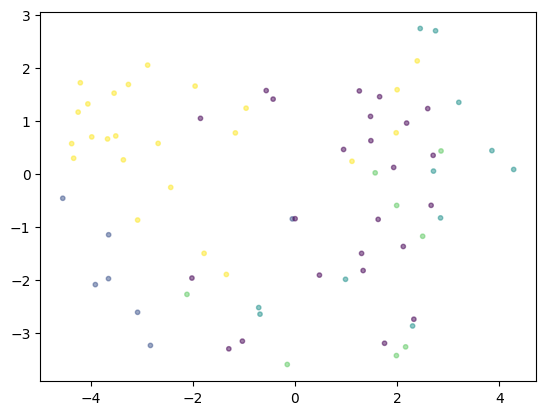

In [49]:
%matplotlib inline

X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label
X_embedded= TSNE(n_components=2, init='random').fit_transform(X_np)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1] , c=labelsNums[:len(X_embedded)], s=10, cmap='viridis' , alpha=0.5 )


In [26]:
def clsembed(snippet):
    inputs = tokenizer(snippet, padding='max_length', max_length=3402, truncation=True, return_tensors='pt').to(device)
    #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
    if(len(inputs)<512):
        with torch.no_grad():
            outs = model_codebert(**inputs)
        cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        return cls
    else:
        print('longtest')
        i = 0
        part_vector =  []
        while ( i < len(inputs)-200) :
            #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
            #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
            input_seg = [tokenizer.cls_token] + inputs[i:i+250] +[tokenizer.sep_token]
            with torch.no_grad():
                ots = model_codebert(**input_seg)
            cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
            #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
            #vector = cls[0].detach().numpy()
            parts.append(cls)
            i = i+100
        return parts

In [27]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
#labels_all = ['async wait','unordered collections','concurrency','time']
def get_class_rep(post_train_embed, post_train_label):
    # Move each tensor to CPU, convert to numpy, and collect in a list
    #post_train_embed = [x.cpu().numpy() for x in post_train_embed]
    # If you want to combine them into a single array (assuming they have the same shape)
    #post_train_embed = np.concatenate(post_train_embed, axis=0)
    representatives = [None] * 5
    for label in range(5):
        indices = np.where(np.atleast_1d(post_train_label) == label)[0]  # Get the indices as an array
        class_vectors = [post_train_embed[i] for i in indices]  # Access each index individually
        class_vectors = [x.cpu().numpy() for x in class_vectors]
        representatives[label] = np.mean(class_vectors, axis=0)
    return representatives

def calculate_normalized_distance(vec1, vec2):
    # Ensure vec1 and vec2 are numpy arrays
    if not isinstance(vec1, np.ndarray):
        vec1 = vec1.cpu().detach().numpy()
    if not isinstance(vec2, np.ndarray):
        vec2 = vec2.cpu().detach().numpy()
    
    # Normalize each vector to have unit length
    norm_vec1 = vec1 / np.linalg.norm(vec1)
    norm_vec2 = vec2 / np.linalg.norm(vec2)
    
    # Calculate Euclidean (L2) distance between the normalized vectors
    distance = np.linalg.norm(norm_vec1 - norm_vec2)
    
    return distance


In [28]:
int_to_label={
    0: 'async wait',
    1: 'unordered collections',
    2: 'concurrency',
    3: 'time',
    4: 'test order dependency'
}


def get_closest_cluster(cluster_representatives, projected_vector):
    distances = [calculate_normalized_distance(rep, projected_vector) for rep in cluster_representatives]
    for i in range(len(distances)):
        distances[i] = np.mean(distances[i])
    closest_cluster_idx = np.argmin(distances)
    return int_to_label[closest_cluster_idx]

In [29]:
embed = post_train_embed
labels = post_train_label
def predict(input_vector):
    modified_vector = siamese_network(input_vector)
    representatives = get_class_rep(embed, labels)
    return get_closest_cluster(representatives, modified_vector)
    
print(predict(train_dataset[10]['anchor']))   
    
print(int_to_label[train_dataset[10]['label']])

test order dependency
test order dependency


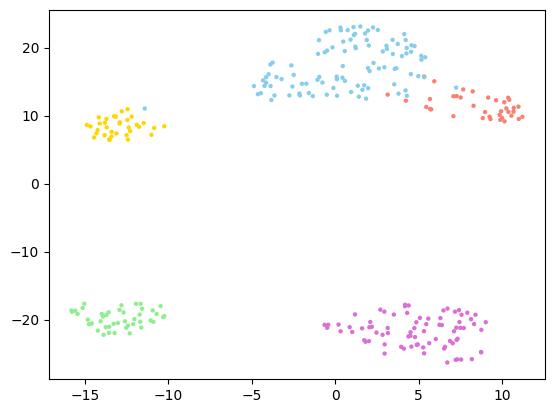

In [30]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# previous best result learing rate: 1e-5
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label

# Define vibrant colors for each category (same as used in the bar plot)
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid']

# Dimensionality reduction with t-SNE
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Scatter plot
for i, label in enumerate(labelsNums[:len(X_embedded)]):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors[label], s=10, alpha=1, edgecolor='none', marker='o')

# Create legend with category labels
# legend_labels = list(shortened_labels.values())  # Use shortened labels for legend
# plt.legend(labels=legend_labels)

plt.show()


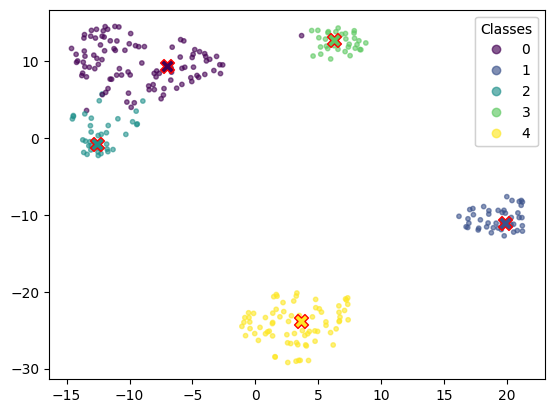

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed, post_train_label, and labelsNums are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Plot the data points
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labelsNums[:len(X_embedded)], s=10, cmap='viridis', alpha=0.6)

# Calculate class representatives
representatives = get_class_rep(post_train_embed, post_train_label)  # Make sure this function returns what you expect

# Get unique labels and their colors from the scatter plot
unique_labels = np.unique(labelsNums[:len(X_embedded)])
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# For each class representative, find the closest point and plot it
for i, rep in enumerate(representatives):
    if rep is not None:
        # Find the closest data point in the original space to this representative
        distances = np.linalg.norm(X_np - rep, axis=1)
        closest_point_index = np.argmin(distances)
        # Use the label of the closest data point to get the correct color
        label_of_closest = labelsNums[closest_point_index]
        color = scatter.cmap(scatter.norm(label_of_closest))
        plt.scatter(X_embedded[closest_point_index, 0], X_embedded[closest_point_index, 1], color=color, edgecolors='red', s=100, marker='X')

# You might want to adjust the legend to make sure it correctly represents your data
# plt.legend()
plt.show()


In [32]:
# from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# # Assuming 'X_embedded' is your t-SNE result and 'labelsNums' are your labels

# # Silhouette Score:
# # - Measures how similar an object is to its own cluster compared to other clusters.
# # - Range: -1 (incorrect clustering) to 1 (highly dense clustering). 
# #   A score close to 1 means that the clusters are well separated and clearly defined.
# silhouette_avg = silhouette_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Silhouette Score: {silhouette_avg}")

# # Davies-Bouldin Index:
# # - Evaluates the clustering quality by measuring the average 'similarity' between each cluster 
# #   and its most similar one. The similarity is based on a ratio of within-cluster distances to between-cluster distances.
# # - Range: 0 to +∞. Lower scores indicate better clustering quality.
# davies_bouldin = davies_bouldin_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Davies-Bouldin Index: {davies_bouldin}")

# # Calinski-Harabasz Index:
# # - Measures the cluster validity based on the ratio between the within-cluster dispersion and the between-cluster dispersion.
# # - Range: Higher values indicate better clustering quality, with no upper limit. Low values indicate clusters with high overlap.
# calinski_harabasz = calinski_harabasz_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Calinski-Harabasz Index: {calinski_harabasz}")


In [33]:
    from sklearn.metrics import f1_score

    int_to_label={
        0: 'async wait',
        1: 'unordered collections',
        2: 'concurrency',
        3: 'time',
        4: 'test order dependency'
    }
    count = 0

    # Assuming val_dataset is iterable and has 'anchor' and 'label' keys
    predicted_labels = []
    true_labels = []

    for item in val_dataset:
        count+=1
        input_vector = item['anchor']  # Your input vector for prediction
        predicted_label = predict(input_vector)  # Get predicted cluster/label
        predicted_labels.append(predicted_label)
        
        true_label = item['label']  # True label
        true_label = int_to_label[int(true_label)]
        true_labels.append(true_label)
        print(count, " ",predicted_label, " " ,true_label)
    # Convert predicted labels to the same format as true_labels if necessary
    # This might include converting cluster IDs to the label format, depending on how your `predict` function outputs the prediction

    # Note: Ensure that your predict function returns labels in a format that matches true_labels or adjust accordingly
    print("loop completed")
    # Calculate F1 Score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Adjust 'average' as necessary
    print(f"F1 Score: {f1}")


1   test order dependency   test order dependency
2   unordered collections   unordered collections
3   time   time
4   async wait   async wait
5   test order dependency   test order dependency
6   concurrency   async wait
7   async wait   unordered collections
8   async wait   concurrency
9   unordered collections   time
10   async wait   concurrency
11   time   async wait
12   concurrency   test order dependency
13   async wait   concurrency
14   unordered collections   unordered collections
15   async wait   async wait
16   async wait   async wait
17   async wait   test order dependency
18   async wait   concurrency
19   async wait   time
20   async wait   async wait
21   test order dependency   test order dependency
22   test order dependency   test order dependency
23   unordered collections   unordered collections
24   concurrency   test order dependency
25   unordered collections   unordered collections
26   async wait   async wait
27   test order dependency   test order depende

                       precision    recall  f1-score   support

           async wait       0.50      0.54      0.52        24
          concurrency       0.29      0.45      0.36        11
test order dependency       0.94      0.67      0.78        24
                 time       0.50      0.38      0.43         8
unordered collections       0.75      0.86      0.80         7

             accuracy                           0.58        74
            macro avg       0.60      0.58      0.58        74
         weighted avg       0.64      0.58      0.60        74


 - Accuracy :  0.58
 - Precision :  0.64
 - Recall :  0.58
 - F1 score :  0.6
 - MCC :  0.45
 - AUC :  0.73


Perfomnaces by categories



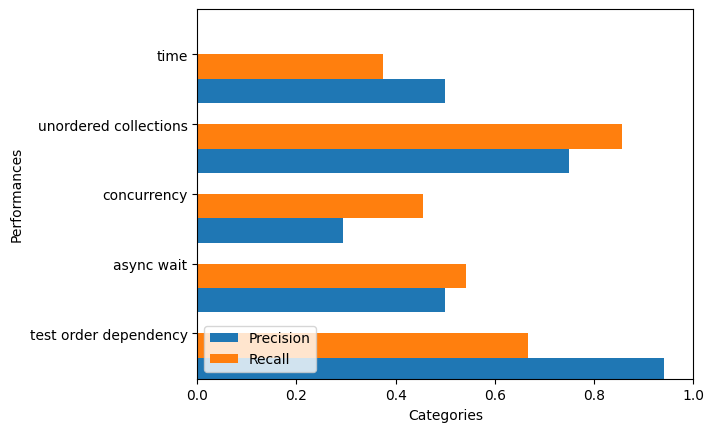



Confusion Matrix 


<AxesSubplot:>

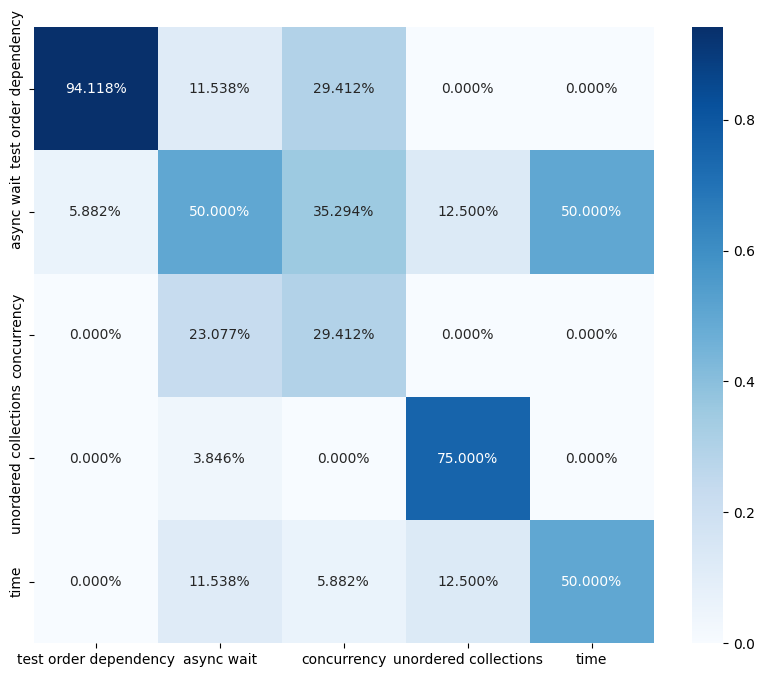

In [34]:
%matplotlib inline
warnings.filterwarnings("ignore")
def multiclass_roc_auc_score(truth, pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)


predicted = predicted_labels
labels = true_labels
unique_labels = list ( set(labels ) )
print (classification_report(labels, predicted))

print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels,  predicted) , 2))
print(' - Precision : ' , np.round( metrics.precision_score(labels,  predicted , average='weighted') , 2))
print(' - Recall : ' , np.round( metrics.recall_score(labels,  predicted , average='weighted') , 2))
print(' - F1 score : ' , np.round( metrics.f1_score(labels,  predicted , average='weighted') , 2))
print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels,  predicted) , 2))
print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels,  predicted),2) )

print("\n\nPerfomnaces by categories\n")


ind = np.arange(len(unique_labels)) 
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[0]
recall = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
ylim=[2*width - 1, len(ind)])
plt.xlim(0,1)
ax.legend(loc='lower left')
ax.set_ylabel("Performances")
ax.set_xlabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(labels,  predicted, labels=unique_labels)
df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
plt.figure(figsize = (10,8))
sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

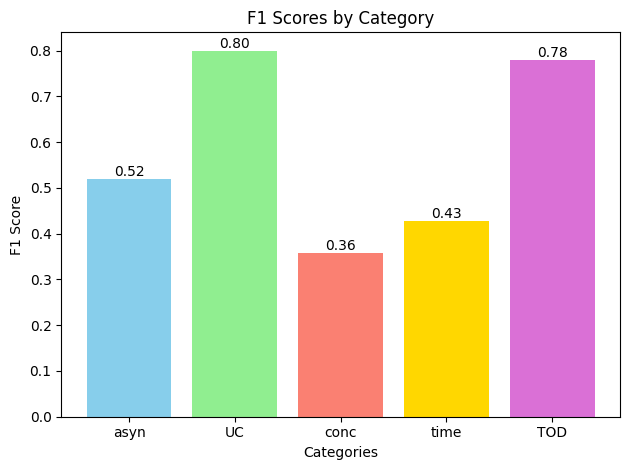

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

# Assuming you have the predicted and true labels as per your previous code
# predicted_labels and true_labels should be lists of labels
int_to_label = {
    0: 'async wait',
    1: 'unordered collections',
    2: 'concurrency',
    3: 'time',
    4: 'test order dependency'
}

# Shortened category names
shortened_labels = {
    'async wait': 'asyn',
    'unordered collections': 'UC',
    'concurrency': 'conc',
    'time': 'time',
    'test order dependency': 'TOD'
}

# Convert true and predicted labels back to integers for F1 score calculation
true_labels_int = [list(int_to_label.keys())[list(int_to_label.values()).index(label)] for label in true_labels]
predicted_labels_int = [list(int_to_label.keys())[list(int_to_label.values()).index(label)] for label in predicted_labels]

# Calculate F1 scores for each category
f1_scores = []
categories = list(int_to_label.values())
for category in categories:
    true_bin = [1 if label == category else 0 for label in true_labels]
    pred_bin = [1 if label == category else 0 for label in predicted_labels]
    f1 = f1_score(true_bin, pred_bin, zero_division=0)
    f1_scores.append(f1)

# Define vibrant colors for each category
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid']

# Create bar plot with shortened category names and vibrant colors
shortened_categories = [shortened_labels[category] for category in categories]
fig, ax = plt.subplots()
bars = ax.bar(shortened_categories, f1_scores, color=colors)

# Add F1 scores on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 0),  
                textcoords="offset points", ha='center', va='bottom')

# Customize the plot
ax.set_xlabel('Categories')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Category')

# Display the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [36]:
# file_path = 'test_data_predictions.csv'

# # Load the compressed CSV file into a DataFrame
# df = pd.read_csv(file_path)

# # Extract the 'TrueLabel' and 'PredictedLabel' columns into separate variables
# labels_flaky = df['TrueLabel'].tolist()
# predicted_flaky = df['PredictedLabel'].tolist()

# print (classification_report(labels, predicted))

# print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels_flaky,  predicted_flaky) , 2))
# print(' - Precision : ' , np.round( metrics.precision_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - Recall : ' , np.round( metrics.recall_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - F1 score : ' , np.round( metrics.f1_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels_flaky,  predicted_flaky) , 2))
# print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels_flaky,  predicted_flaky),2) )

# print("\n\nPerfomnaces by categories\n")


# ind = np.arange(len(unique_labels)) 
# width = 0.35
# fig, ax = plt.subplots()
# precision = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[0]
# recall = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[1]
# ax.barh(ind - width/2, precision, width, label='Precision')
# ax.barh(ind + width/2, recall, width, label='Recall')
# ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
# ylim=[2*width - 1, len(ind)])
# plt.xlim(0,1)
# ax.legend(loc='upper right')
# ax.set_xlabel("Performances")
# ax.set_ylabel("Categories")
# plt.show()

# print("\n\nConfusion Matrix ")

# mat = confusion_matrix(labels_flaky,  predicted_flaky, labels=unique_labels)
# df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
# plt.figure(figsize = (10,8))
# sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

In [37]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import metrics

# precision_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[0]
# recall_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[1]
# # And assuming 'unique_labels' is defined as before

# ind = np.arange(len(unique_labels))  # the x locations for the groups
# width = 0.2  # the width of the bars

# fig, ax = plt.subplots(figsize=(14, 10))  # Adjust the figure size as needed

# # Using a set of contrasting, darker colors
# colors = ['blue', 'green', 'red', 'orange']

# # Plotting Precision and Recall for Your Model
# rects1 = ax.bar(ind - width*1.5, precision_our_model, width, label='Our Precision', color=colors[0])
# rects2 = ax.bar(ind - width/2, recall_our_model, width, label='Our Recall', color=colors[1])

# # Plotting Precision and Recall for Flaky Model
# rects3 = ax.bar(ind + width/2, precision_flaky, width, label='FlakyCat Precision', color=colors[2])
# rects4 = ax.bar(ind + width*1.5, recall_flaky, width, label='FlakyCat Recall', color=colors[3])

# # Add some text for labels, title, and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Class-wise Precision and Recall for Our Model vs. FlakyCat Model')
# ax.set_xticks(ind)
# ax.set_xticklabels(unique_labels, rotation=45, ha="right")  # Rotate for better label visibility
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place the legend outside the figure

# # Optional: Adding scores above bars
# ax.bar_label(rects1, padding=3, fmt='%.2f')
# ax.bar_label(rects2, padding=3, fmt='%.2f')
# ax.bar_label(rects3, padding=3, fmt='%.2f')
# ax.bar_label(rects4, padding=3, fmt='%.2f')

# fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to make space for the legend outside

# plt.show()


In [38]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming metrics have been calculated and stored in variables for both models.
# # Example metric variables: accuracy, precision, recall, f1_score, mcc, auc for the original model
# # And similarly named variables with a '_flaky' suffix for the comparison model.

# metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', 'AUC']
# your_model_metrics = [
#     np.round(metrics.accuracy_score(labels, predicted), 2),
#     np.round(metrics.precision_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.recall_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.f1_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.matthews_corrcoef(labels, predicted), 2),
#     np.round(multiclass_roc_auc_score(labels, predicted), 2)
# ]

# flaky_model_metrics = [
#     np.round(metrics.accuracy_score(labels_flaky, predicted_flaky), 2),
#     np.round(metrics.precision_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.recall_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.f1_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.matthews_corrcoef(labels_flaky, predicted_flaky), 2),
#     np.round(multiclass_roc_auc_score(labels_flaky, predicted_flaky), 2)
# ]

# x = np.arange(len(metrics_labels))  # the label locations
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, your_model_metrics, width, label='Our Model')
# rects2 = ax.bar(x + width/2, flaky_model_metrics, width, label='FlakyCat Model')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Metrics Comparison between Our Model and FlakyCat Model')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics_labels)
# ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# fig.tight_layout()

# plt.show()


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
def extract_projections(siamese_network, dataloader):
    projections = []
    labels = []
    for batch in dataloader:
        label = batch["label"]
        anchor = batch["anchor"]
        projection = siamese_network(anchor)
        
        projections.append(projection.cpu().detach().numpy())
        labels.append(label.numpy())
    projections = np.vstack(projections)
    labels = np.hstack(labels)
    return projections, labels

In [40]:
projections, labels = extract_projections(siamese_network, train_dataloader)
val_projections, val_labels = extract_projections(siamese_network, val_dataloader)

In [41]:
print(len(projections), len(train_dataloader))

295 37


In [42]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(projections, labels)

# Train SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(projections, labels)

SVC(kernel='linear', random_state=42)

In [43]:
# Evaluate Random Forest Classifier
rf_predictions = rf_classifier.predict(val_projections)
rf_accuracy = accuracy_score(val_labels, rf_predictions)
rf_f1 = f1_score(val_labels, rf_predictions, average='weighted')
print(f"Random Forest Classifier Accuracy: {rf_accuracy}, F1: {rf_f1}")

# Evaluate SVM Classifier
svm_predictions = svm_classifier.predict(val_projections)
svm_accuracy = accuracy_score(val_labels, svm_predictions)
svm_f1 = f1_score(val_labels, svm_predictions, average='weighted')
print(f"SVM Classifier Accuracy: {svm_accuracy}, F1:{svm_f1}")

Random Forest Classifier Accuracy: 0.6351351351351351, F1: 0.6345837881945593
SVM Classifier Accuracy: 0.7027027027027027, F1:0.6916645517923825
